In [14]:
import pandas as pd
import numpy as np

In [15]:
train_df = pd.read_csv('training.csv')

In [16]:
# txkey全部都是唯一資料，刪除不用
train_df.drop('txkey', axis=1, inplace=True)

## Setup data type

In [17]:
train_df[['chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg',\
          'stocn','scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk','label']] = \
    train_df[['chid','cano','contp','etymd','mchno','acqic','mcc','ecfg','insfg','bnsfg','stocn',\
              'scity','stscd','ovrlt','flbmk','hcefg','csmcu','flg_3dsmk','label']].astype('category')

#train_df[train_df.select_dtypes(include='int64').columns] = \
#    train_df[train_df.select_dtypes(include='int64').columns].astype('int32')

#train_df[train_df.select_dtypes(include='float64').columns] = \
#    train_df[train_df.select_dtypes(include='float64').columns].astype('float32')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688526 entries, 0 to 8688525
Data columns (total 25 columns):
 #   Column     Dtype   
---  ------     -----   
 0   locdt      int64   
 1   loctm      int64   
 2   chid       category
 3   cano       category
 4   contp      category
 5   etymd      category
 6   mchno      category
 7   acqic      category
 8   mcc        category
 9   conam      float64 
 10  ecfg       category
 11  insfg      category
 12  iterm      float64 
 13  bnsfg      category
 14  flam1      int64   
 15  stocn      category
 16  scity      category
 17  stscd      category
 18  ovrlt      category
 19  flbmk      category
 20  hcefg      category
 21  csmcu      category
 22  csmam      int64   
 23  flg_3dsmk  category
 24  label      category
dtypes: category(19), float64(2), int64(4)
memory usage: 701.2 MB


In [18]:
# Check for missing values
print(train_df.isnull().sum())

locdt              0
loctm              0
chid               0
cano               0
contp              0
etymd         203455
mchno              0
acqic              0
mcc             4550
conam              0
ecfg               0
insfg              0
iterm              0
bnsfg              0
flam1              0
stocn            600
scity         266066
stscd        8665195
ovrlt              0
flbmk              0
hcefg         286656
csmcu         498657
csmam              0
flg_3dsmk          0
label              0
dtype: int64


### Check 'stscd' status code

  stscd        0      1
0   0.0      746     53
1   1.0    11959  10426
2   2.0      132      0
3   3.0        2      0
4   4.0       13      0
5    NA  8643645  21550


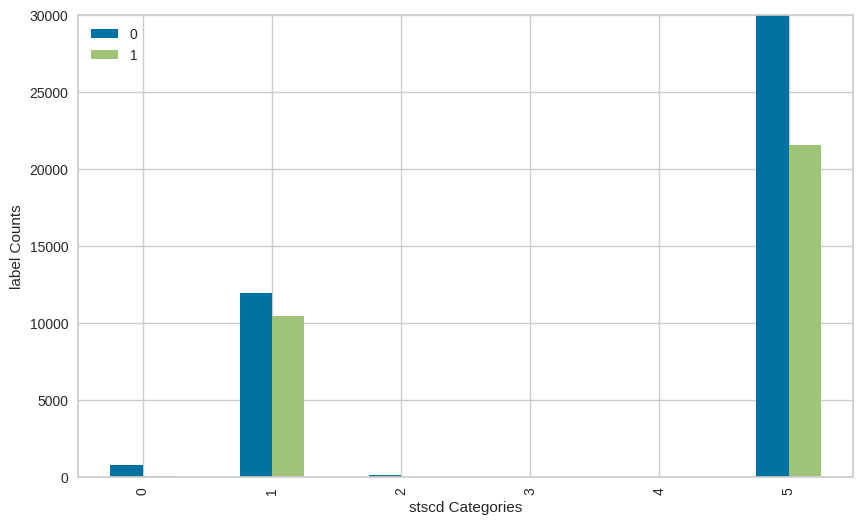

In [19]:
import matplotlib.pyplot as plt
## check stscd data distribution
df = train_df.copy()
df['stscd']=df['stscd'].cat.add_categories("NA").fillna("NA")
stscd_table = df[['label','stscd']].pivot_table(index='stscd', columns='label', aggfunc=len, fill_value=0)
stscd_table = stscd_table.reset_index().rename_axis(None, axis=1).rename_axis(None, axis=0)
print(stscd_table)
stscd_table.plot(kind='bar', stacked=False, figsize=(10, 6)).set_ylim(0, 30000) 
plt.xlabel('stscd Categories')
plt.ylabel('label Counts')
plt.show()

## Add transformed features

In [20]:
# Binary indicator for missing values
train_df['stscd_missing'] = train_df['stscd'].isnull().astype('category')# should be category
print(train_df['stscd_missing'].value_counts())

True     8665195
False      23331
Name: stscd_missing, dtype: int64


## Add time series column

In [21]:
train_df['sequence'] = (train_df.sort_values(by=['chid', 'locdt', 'loctm']).groupby('chid').cumcount() + 1).astype('int32')

In [22]:
# 指定要填充的欄位
columns_to_fill = ['etymd', 'mcc', 'stocn', 'scity', 'stscd', 'hcefg', 'csmcu']

# 將 "unknown" 添加到類別中，如果已經存在，則忽略
for column in columns_to_fill:
    train_df[column] = train_df[column].cat.add_categories('-1').fillna('-1')

# Check for missing values
print(train_df.isnull().sum())
print(train_df.info())

locdt            0
loctm            0
chid             0
cano             0
contp            0
etymd            0
mchno            0
acqic            0
mcc              0
conam            0
ecfg             0
insfg            0
iterm            0
bnsfg            0
flam1            0
stocn            0
scity            0
stscd            0
ovrlt            0
flbmk            0
hcefg            0
csmcu            0
csmam            0
flg_3dsmk        0
label            0
stscd_missing    0
sequence         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8688526 entries, 0 to 8688525
Data columns (total 27 columns):
 #   Column         Dtype   
---  ------         -----   
 0   locdt          int64   
 1   loctm          int64   
 2   chid           category
 3   cano           category
 4   contp          category
 5   etymd          category
 6   mchno          category
 7   acqic          category
 8   mcc            category
 9   conam          float64 
 10  ecfg    

## PyCaret

In [23]:
# label轉成數值，不轉會出現error
train_df['label'] = train_df['label'].astype('int32')

In [24]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [25]:
categorical_feature = [col for col in train_df.columns if train_df[col].dtype == 'category' and col != 'label']
print(categorical_feature)
print('Number of categorical feature:', len(categorical_feature))

['chid', 'cano', 'contp', 'etymd', 'mchno', 'acqic', 'mcc', 'ecfg', 'insfg', 'bnsfg', 'stocn', 'scity', 'stscd', 'ovrlt', 'flbmk', 'hcefg', 'csmcu', 'flg_3dsmk', 'stscd_missing']
Number of categorical feature: 19


In [26]:
train_df[train_df.chid == '00002dd97e50e1c990d7ca37b95e33a95eb01baff58780a5b532546e36c3cf33']

,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,conam,...,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk,label,stscd_missing,sequence
635503,24,194420,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,4.0,751399cbe1a9c9b880a453fbf12fc7fae3230500259b3a...,d0c4efb29970311d8492fbfb19616b631f38593cafff95...,288.0,600.0,...,-1,0,0,6.0,70.0,602,0,0,True,3
651825,3,110301,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,1.0,f8cd89aa68548edfd1caabc1d7e2def0796e132d376e25...,6dd1df1ce31eab6dc702ab214c0ca88b59029dd4bd987b...,233.0,616.0,...,-1,0,0,6.0,70.0,618,0,0,True,1
2639277,35,144909,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,1.0,f8cd89aa68548edfd1caabc1d7e2def0796e132d376e25...,6dd1df1ce31eab6dc702ab214c0ca88b59029dd4bd987b...,233.0,577.0,...,-1,0,0,6.0,70.0,579,0,0,True,4
3335685,24,160133,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,4.0,d2a40c8cb4b39d13b40ba5bcb5a38b5671e0e908bbf2e3...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,379.0,3180.0,...,-1,0,0,6.0,70.0,3191,0,0,True,2
3461290,39,214525,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,4.0,cb05956865c1e76806aecd6cfb4b176bae15b0f010775a...,d0c4efb29970311d8492fbfb19616b631f38593cafff95...,288.0,500.0,...,-1,0,0,6.0,70.0,502,0,0,True,6
7037751,38,182803,00002dd97e50e1c990d7ca37b95e33a95eb01baff58780...,4060ba94038914d75fd8437a581b83013d88af990dec84...,5,4.0,c84e694cca187223d9e2ff549a281e7354df83786d5a96...,d0c4efb29970311d8492fbfb19616b631f38593cafff95...,288.0,600.0,...,-1,0,0,6.0,70.0,602,0,0,True,5


In [28]:
# init setup on exp
exp.setup(train_df, target='label',
          fix_imbalance=True, fix_imbalance_method='RandomOverSampler',
          n_jobs=16,fold=5,
          log_experiment=True, experiment_name='Exp_1121_add_stscd_time',
          session_id=6996)

ValueError: Cannot cast object dtype to float64

In [19]:
exp.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [20]:
# compare selected models
include_models = ['rf', 'lightgbm'] 
best = exp.compare_models(include=include_models, sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9987,0.8948,0.6878,0.9620,0.8021,0.8015,0.8129,174.9520
lightgbm,Light Gradient Boosting Machine,0.9986,0.9465,0.7303,0.8832,0.7980,0.7974,0.8017,136.3740


In [21]:
exp.save_model(best, '00_Exp_model_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam',
                                              'stscd_missing'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer...
                  RandomForestClassifie

In [20]:
best = exp.load_model('00_Exp_model_pipeline')

Transformation Pipeline and Model Successfully Loaded


In [22]:
best

Pipeline(memory=FastMemory(location=/dev/shm/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['locdt', 'loctm', 'conam', 'iterm',
                                             'flam1', 'csmam',
                                             'stscd_missing'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('cate...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=30,
                                        oob_score=False, random_state=6969,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [23]:
tune_best = exp.tune_model(best, optimize='F1',early_stopping=True)
# 250G RAM overload

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:35:46
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


Fitting 5 folds for each of 10 candidates, totalling 50 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
tune_best

In [ ]:
exp.save_model(tune_best, '00_tuned_model_pipeline')

### lighGBM

In [51]:
# init setup on exp
exp.setup(train_df, target='label',
          fix_imbalance=True, fix_imbalance_method='RandomOverSampler',
          n_jobs=8,
          fold=10,
          log_experiment=True, experiment_name='00_Exp_lighGBM',
          session_id=6970)

,Description,Value
0,Session id,6970
1,Target,label
2,Target type,Binary
3,Original data shape,"(8688526, 26)"
4,Transformed data shape,"(14725654, 58)"
5,Transformed train set shape,"(12119096, 58)"
6,Transformed test set shape,"(2606558, 58)"
7,Ordinal features,6
8,Numeric features,7
9,Categorical features,18


In [52]:
LightGBM = exp.compare_models(include=['lightgbm'], sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9986,0.9681,0.7160,0.8843,0.7912,0.7905,0.7950,44.3500


In [53]:
exp.save_model(LightGBM, '00_Exp_lightgbm_cv10_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['locdt', 'loctm', 'conam', 'iterm',
                                              'flam1', 'csmam',
                                              'stscd_missing'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer...
                  LGBMClassifier(boosti

In [54]:
tune_lightgbm = exp.tune_model(LightGBM, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9988,0.9868,0.7172,0.9311,0.8103,0.8097,0.8166
1,0.9987,0.9896,0.7186,0.9185,0.8063,0.8057,0.8118
2,0.9987,0.9889,0.7136,0.9222,0.8046,0.8040,0.8107
3,0.9988,0.9884,0.7248,0.9259,0.8131,0.8125,0.8186
4,0.9987,0.9879,0.7079,0.9243,0.8017,0.8011,0.8083
5,0.9987,0.9945,0.7168,0.9188,0.8053,0.8047,0.8109
6,0.9988,0.9893,0.7252,0.9286,0.8144,0.8138,0.8201
7,0.9988,0.9908,0.7186,0.9318,0.8114,0.8108,0.8177
8,0.9987,0.9884,0.7239,0.9195,0.8101,0.8095,0.8153


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 5453593, number of negative: 5453593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.118854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

In [ ]:
exp.save_model(tune_lightgbm, '00_tune_lightgbm_cv10_pipeline')